Step 0: copy this Jupyter notebook to your own Google Drive so that you can edit it. 

You are encouraged to write your solution to the paper exercises here as well, so that they would be exported into the same PDF file. As a reminder, the text cells support Markdown, so it's easy to write equations, such as $f(x) = x^2$, here. 

# Data Preparation 

Step 1: copy (i.e., add a shortcut of) hw1.zip from my Google Drive to yours, preferably to the folder `TTIC31220-Winter21/` under the root of your Google Drive.

Step 2: run the cell below to prepare data for your experiments. Note: once you close this page or the page says "disconnected", you will probably need to rerun the cell again, but you definitely don't need to rerun all probably time-consuming experiments. 

In [3]:
from google.colab import files, drive
drive.mount('/content/drive')# follow the prompt to mount your Google Drive
! cp drive/MyDrive/TTIC31220-Winter21/hw1.zip ./hw1.zip
# Note: you might need to change the above path if hw1.zip is in a different 
#   folder in your Google drive. As a hint, your Google drive root folder is 
#   /content/drive/ or drive/
! unzip hw1.zip 


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly&response_type=code

Enter your authorization code:
4/1AY0e-g4mwgAuPN9LANDWo_iZ9E1Hk2MlwTNNDHhaVIFEdssxBj6dAsoIWPE
Mounted at /content/drive
Archive:  hw1.zip
   creating: data/
  inflating: data/noisy_two_view_distribute.mat  
  inflating: data/idx.mat            
  inflating: data/noisy_distribute.mat  
  inflating: data/original_distribute.mat  
  inflating: dataset.py              
  inflating: plot.py                 
  inflating: svm.py                  
  inflating: utils.p

Question: 3.1. 
Input: data matrix with dimension N*d

Output: would be the principal dimension, the eigenvectors of data variance matrix

Optimization problem: eigen decomposition

# Coding Exercise
The packages imported below should be enough, but feel free to import others you would like to use. 
If some package you would like to import is not installed in the Colab default environment, you can call `! pip install your_package` to install it.

In [4]:
#@title library import
%matplotlib inline
from matplotlib import pyplot as plt
import argparse
import math
import numpy as np
import scipy.io as sio
import sklearn
import os
import time
from scipy.linalg import sqrtm

from plot import plot_images, plot_embedding, plot_embedding_annotation, \
  plot_confusion_matrix
from dataset import read_mnist, read_mnist_twoview
from utils import resize
from svm import linear_svm

In [9]:
#@title PCA & CCA
"""
Basic classes for PCA and CCA
"""

class PCA(object):
    def __init__(self, n_components):
        """
        Set up PCA
        ------
        input
            n_components: number of components to keep
        """
        self.n_components = n_components

    def fit(self, X):
        """
        fit the model with training data
        --------
        Input 
            X, 2d-array of shape (n_samples, n_features): data matrix
        """
        n_features = X.shape[1]

        #input x shape(N,d)
        #output w shape(n_components,n_features) (k,d)
        self.W = np.zeros((self.n_components, n_features))
        self.mu = np.zeros(n_features)
        
        # TODO (add your code below): Compute projection matrix W and 
        #   data mean mu

        self.mu = np.mean(X, axis=0)
        cov = np.dot((X-self.mu).transpose(),(X-self.mu))
        eig_va, eig_ve = np.linalg.eig(cov)
        p = np.argsort(np.abs(eig_va))[::-1] 
        eig_ve = eig_ve[:, p]
        self.W = eig_ve[:,:self.n_components].transpose()
        # (add your code above)
    
    def fit_svd(self, X):
        """
        fit the model with training data
        --------
        Input 
            X, 2d-array of shape (n_samples, n_features): data matrix
        """
        n_features = X.shape[1]

        #input x shape(N,d)
        #output w shape(n_components,n_features) (k,d)
        self.W = np.zeros((self.n_components, n_features))
        self.mu = np.zeros(n_features)
        
        # TODO (add your code below): Compute projection matrix W and 
        #   data mean mu

        self.mu = np.mean(X, axis=0)
        u,s,vh = np.linalg.svd((X-self.mu),full_matrices=False)
        self.W = vh.transpose()[:,:self.n_components].transpose()
        # (add your code above)


    def transform(self, X):
        """
        apply PCA on X
        --------
        Input
            X, 2d-array of shape (n_samples, n_features): data matrix
        Output
            Z, 2d-array of shape (n_samples, n_components): feature matrix
        """
        # TODO (add your code below): Compute Z
        Z = np.dot(self.W,(X-self.mu).transpose()).transpose()

        # (add your code above)
        return Z
    
    def reconstruct(self, Z):
        """
        transform feature Z back to the original feature space
        --------
        Input
            Z, 2d-array of shape (n_samps, n_components): feature matrix
        Ourput
            X, 2d-array of shape (n_samps, n_feats): reconstructed data matrix
        """
        # TODO (add your code below): Compute X
        X = np.dot(Z,self.W)+self.mu

        # (add your code above)
        return X 


class CCA(object):
    def __init__(self, n_components, r1, r2):
        """
        Set up CCA
        ------
        Input       
            n_components: number of components to keep
            r1, r2: regularization coefficient on view 1 and view 2
        """
        self.n_components, self.r1, self.r2 = n_components, r1, r2

    def fit(self, X, Y):
        """
        fit the model with training data
        --------
        Input 
            X, 2d-array of shape (n_samps, view1_feats): data matrix of view 1
            Y, 2d-array of shape (n_samps, view2_feats): data matrix of view 2
        """
        nx_features, ny_features = X.shape[1], Y.shape[1]
        self.Wx = np.zeros((nx_features, self.n_components))
        self.Wy = np.zeros((ny_features, self.n_components))
        self.mX, self.mY = np.zeros(nx_features), np.zeros(ny_features)
        # TODO (add your code below): Compute projection matrices (Wx, Wy) and 
        #   data mean (mX, mY) of two views
        n_samples = X.shape[0]
        self.mX = np.mean(X, axis=0)
        self.mY = np.mean(Y, axis=0)

        X_norm = X-self.mX
        Y_norm = Y-self.mY
        cov_xy = np.matmul(X_norm.T, Y_norm) / (n_samples - 1)
        cov_yx = np.matmul(Y_norm.T, X_norm) / (n_samples - 1)
        cov_xx = np.matmul(X_norm.T, X_norm) / (n_samples - 1)
        cov_yy = np.matmul(Y_norm.T, Y_norm) / (n_samples - 1)
        
        cov_xx = cov_xx + self.r1*np.eye(cov_xx.shape[0])
        cov_yy = cov_yy + self.r2*np.eye(cov_yy.shape[0])

        matr = np.linalg.inv(cov_xx).dot(cov_xy).dot(np.linalg.inv(cov_yy)).dot(cov_yx)

        eig_va, eig_ve = np.linalg.eig(matr)
        p = np.argsort(np.abs(eig_va))[::-1] 
        eig_ve = eig_ve[:, p]
        self.Wx = eig_ve[:,:self.n_components]
        self.Wy = np.linalg.inv(cov_yy).dot(cov_yx).dot(self.Wx)
        # (add your code above)

    def transform(self, X, view=1):
        """
        apply CCA on data X of a given view
        --------
        Input 
            X, 2d-array of shape (n_samples, n_features): data matrix
            view: view index (1 or 2)
        Output
            Z, 2d-array of shape (n_samples, n_components): feature matrix
        """
        # TODO (add your code below): Compute Z given X and view 
        
        if view == 1:
          Z = (X-self.mX).dot(self.Wx)
        else:
          Z = (X-self.mY).dot(self.Wy)
        # (add your code above)
        return Z
    
    def reconstruct(self, Z, view=1):
        """
        given the view id, transform feature Z back to the original feature 
        space 
        --------
        Input 
            Z, 2d-array of shape (n_samps, n_components): feature matrix
        Output
            X, 2d-array of shape (n_samps, n_feats): reconstructed data matrix
        """
        # TODO (add your code below): Compute X given Z and view 
        
        if view == 1:
          X = Z.dot(self.Wx.T)+self.mX
        else:
          X = Z.dot(self.Wy.T)+self.mY
        # (add your code above)
        return X

## Part 1: Single View Dimensionality Reduction with PCA

Data path is: data/noisy_distribute.mat


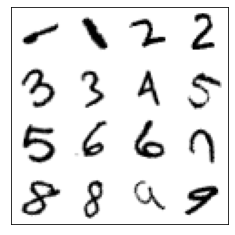

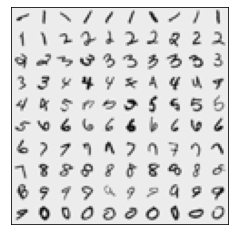

In [6]:
#@title loading data
np.random.seed(1)

datapath = 'data/noisy_distribute.mat'
print("Data path is: %s" % datapath)

train_data, dev_data, test_data = read_mnist(datapath)
test_x_sample = test_data
test_x_image = np.reshape(
        test_x_sample, [test_x_sample.shape[0], 28, 28]
    ).transpose(0, 2, 1)
train_x_sample = train_data.images
train_x_image = np.reshape(
        train_x_sample, [train_x_sample.shape[0], 28, 28]
    ).transpose(0, 2, 1)
train_y_sample = np.reshape(train_data.labels, [train_x_sample.shape[0]])
dev_x_sample = dev_data.images
dev_x_image = np.reshape(
        dev_x_sample, [dev_x_sample.shape[0], 28, 28]
    ).transpose(0, 2, 1)
dev_y_sample = np.reshape(dev_data.labels, [dev_x_sample.shape[0]])

"""
1. Visualize a few input digits
"""
ax = plot_images(train_x_image[::3000], 4, 4, 28, 28)
plt.show()


"""
2. Visualize more input digits, using smaller scale
"""

train_x_rescale = resize(train_x_image, 10, 10)
ax = plot_images(train_x_rescale[::500], 10, 10, 10, 10)
plt.show()

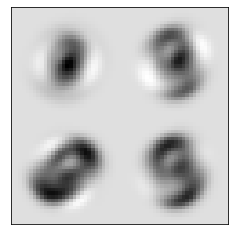

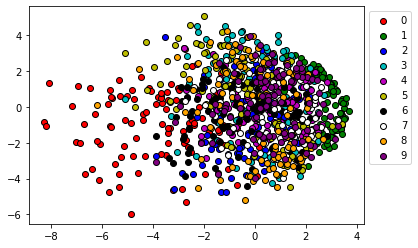

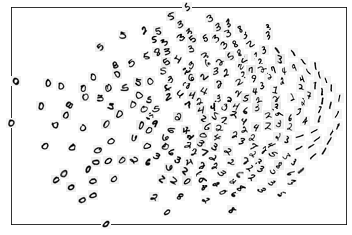

In [69]:

"""
3. Reduce dimensionality with PCA
"""
n_components = 2
pca = PCA(n_components)

# train
pca.fit(train_x_sample)

# transform
z_pca_dev = pca.transform(dev_x_sample)

# reconstruct
dev_x_image_hat = pca.reconstruct(z_pca_dev).reshape(
    (-1, 28, 28)).transpose((0, 2, 1))
ax = plot_images(dev_x_image_hat[::2500], 2, 2, 28, 28)
plt.show()

# Visualization without annotation
vis_sample_rate = 10
plot_embedding(
    z_pca_dev[::vis_sample_rate, :2], dev_y_sample[::vis_sample_rate]
)
plt.show()

# Visualization with annotation
dev_x_rescale = resize(dev_x_image,10,10)
plot_embedding_annotation(
    z_pca_dev[::vis_sample_rate, :2], dev_x_rescale[::vis_sample_rate], 0.001
)
plt.show()

If your code works well, the last image above is what we would like for 3.3.1. 

### Answer to 3.3.1 (TODO: add your answer)
The PC for vertical axis is denote if there is weights on upper left and lower right. The PC for horizontal axis is about if there is any weights in the middle. 

Now let's work for 3.3.2: how many principal components are sufficient enough? 


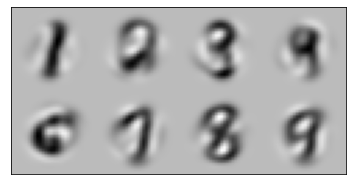

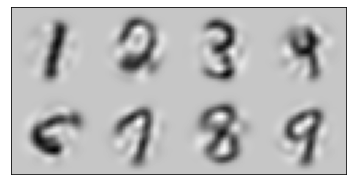

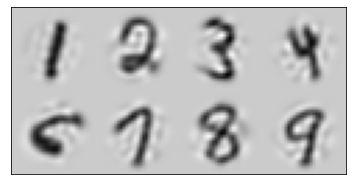

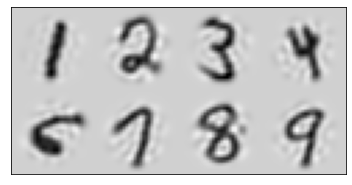

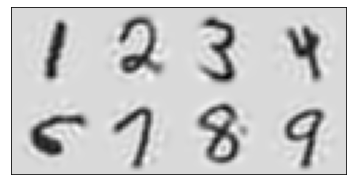

In [11]:
#@title 3.3.2
n_component_candidates = [5,10,100,300,500,700
]  
# TODO: add potential n_components that you would like to test to the above list
# recall that the original data is 28 * 28 = 784D

n_component_candidates = [20,40,60,80,100
]  

for n_components in n_component_candidates:
    # TODO: (add your code below) compress the data with PCA and the specific 
    #   n_components, reconstruct the digits, and plot some examples 
    # hint: feel free to copy code from the above cells. 

    pca = PCA(n_components)

    # train
    pca.fit(train_x_sample)

    # transform
    z_pca_dev = pca.transform(dev_x_sample)

    # reconstruct
    dev_x_image_hat = pca.reconstruct(z_pca_dev).reshape(
        (-1, 28, 28)).transpose((0, 2, 1))
    ax = plot_images(dev_x_image_hat[::1250], 2, 4, 28, 28)
    plt.show()    

    # (add your code above)

### Answer to 3.3.2 (TODO: add your answer)
Approximately 80 PC is sufficient

In [70]:
"""
4. Classification with SVM
"""

# train on raw image
start_time = time.time()
raw_best_error_dev, raw_pred = linear_svm(
    train_x_sample, train_y_sample, 
    dev_x_sample, dev_y_sample, 
    test_x_sample
)
end_time = time.time()
print(f'Training time = {end_time - start_time:.2f} seconds')

# Note: It takes me ~3 minutes to finish this cell, so don't be worried if it 
#   doesn't give immediate output. Typically, it's a little slow (but hopfully 
#    tolerable) to train SVMs with a large dimensionality of features. 


Performing linear SVM!
C = 0.010000, dev error = 0.197300
C = 0.100000, dev error = 0.200000
C = 1.000000, dev error = 0.203700
Selected classifier with best dev error 0.197300
Training time = 173.41 seconds


In [71]:
# TODO: (add your code below) train on 20-D PCA features and monitor 
#   the SVM training time 

start_time = time.time()
n_components = 20
pca = PCA(n_components)

# train
pca.fit(train_x_sample)

# transform
z_pca_tr = pca.transform(train_x_sample)
z_pca_dev = pca.transform(dev_x_sample)
z_pca_te = pca.transform(test_x_sample)


svm_st_time = time.time()
pc_best_error_dev, pc_pred = linear_svm(
    z_pca_tr, train_y_sample, 
    z_pca_dev, dev_y_sample, 
    z_pca_te
)
end_time = time.time()
print(f'Total time = {end_time - start_time:.2f} seconds')
print(f'Training time = {end_time - svm_st_time:.2f} seconds')
# (add your code above)

Performing linear SVM!
C = 0.010000, dev error = 0.275200
C = 0.100000, dev error = 0.273200
C = 1.000000, dev error = 0.273000
Selected classifier with best dev error 0.273000
Total time = 9.61 seconds
Training time = 5.66 seconds


### Answer to 3.4.1 (TODO: add your answer)

Two time is recorded for performing PCA and then do SVM. One is the total time, the other one is only for the SVM time. For number of PC = 20, the total time is 9.61 seconds, reduced from 224.9 seconds (raw data), however, the error rate also increased from 0.20 to 0.27. 

Performing linear SVM!
C = 0.010000, dev error = 0.275200
C = 0.100000, dev error = 0.273200
C = 1.000000, dev error = 0.273000
Selected classifier with best dev error 0.273000
Total time = 9.20 seconds
Training time = 5.83 seconds
Performing linear SVM!
C = 0.010000, dev error = 0.231500
C = 0.100000, dev error = 0.229600
C = 1.000000, dev error = 0.229300
Selected classifier with best dev error 0.229300
Total time = 12.68 seconds
Training time = 9.45 seconds
Performing linear SVM!
C = 0.010000, dev error = 0.217100
C = 0.100000, dev error = 0.214100
C = 1.000000, dev error = 0.213800
Selected classifier with best dev error 0.213800
Total time = 20.08 seconds
Training time = 16.67 seconds
Performing linear SVM!
C = 0.010000, dev error = 0.210600
C = 0.100000, dev error = 0.208700
C = 1.000000, dev error = 0.208300
Selected classifier with best dev error 0.208300
Total time = 28.64 seconds
Training time = 25.31 seconds
Performing linear SVM!
C = 0.010000, dev error = 0.208600
C = 0.100

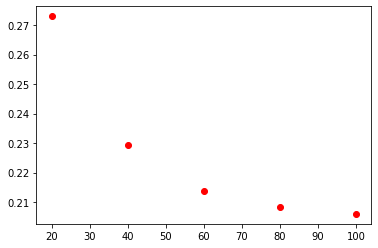

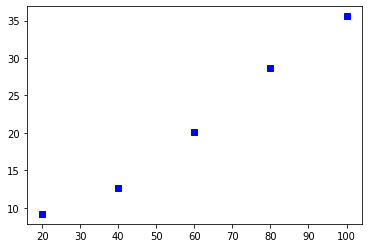

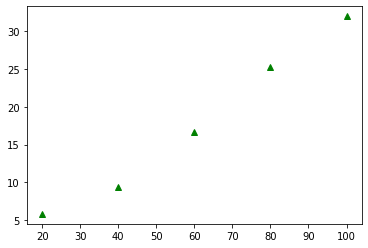

In [73]:
# TODO (add your code below) Write code to complete 3.4.2 here.
#   Feel free to copy code from above cells.

n_component_candidates = [20,40,60,80,100
]  

total_time_list=[]
svm_time_list =[]
error_list=[]

for n_components in n_component_candidates:

  start_time = time.time()
  
  pca = PCA(n_components)

  # train
  pca.fit(train_x_sample)

  # transform
  z_pca_tr = pca.transform(train_x_sample)
  z_pca_dev = pca.transform(dev_x_sample)
  z_pca_te = pca.transform(test_x_sample)


  svm_st_time = time.time()
  pc_best_error_dev, pc_pred = linear_svm(
      z_pca_tr, train_y_sample, 
      z_pca_dev, dev_y_sample, 
      z_pca_te
  )
  end_time = time.time()
  error_list.append(pc_best_error_dev)
  print(f'Total time = {end_time - start_time:.2f} seconds')
  total_time_list.append(end_time - start_time)
  svm_time_list.append(end_time - svm_st_time)
  print(f'Training time = {end_time - svm_st_time:.2f} seconds')
# (add your code above)
plt.plot(n_component_candidates, error_list, 'ro')
plt.show()
plt.plot(n_component_candidates, total_time_list, 'bs')
plt.show()
plt.plot(n_component_candidates, svm_time_list, 'g^')
plt.show()
# (add your code above)

### Answer to 3.4.2 (TODO: add your answer)
The error rate is as expected decreasing as number of PC increased. The time generally increased with more PC. From the plotted graph, it is clear when number of PC = 100, it has similar error rate as the raw data matrix. But time is reduced significantly to 32 seconds.


In [14]:
datapath = 'data/noisy_distribute.mat'
print("Data path is: %s" % datapath)

# load two sets of 50 examples
ids = sio.loadmat('data/idx.mat')
train_x_small_set = dict()
train_y_small_set = dict()
train_x_small_set['p1'] = train_x_sample[ids['p1'].reshape(-1)]
train_y_small_set['p1'] = train_y_sample[ids['p1'].reshape(-1)]
train_x_small_set['p2'] = train_x_sample[ids['p2'].reshape(-1)]
train_y_small_set['p2'] = train_y_sample[ids['p2'].reshape(-1)]

Data path is: data/noisy_distribute.mat


Performing linear SVM!
C = 0.010000, dev error = 0.586400
C = 0.100000, dev error = 0.570400
C = 1.000000, dev error = 0.576300
Selected classifier with best dev error 0.570400
Training time for p1 = 0.30 seconds
Performing linear SVM!
C = 0.010000, dev error = 0.844800
C = 0.100000, dev error = 0.834900
C = 1.000000, dev error = 0.761800
Selected classifier with best dev error 0.761800
Total time = 3.00 seconds
Performing linear SVM!
C = 0.010000, dev error = 0.821400
C = 0.100000, dev error = 0.813000
C = 1.000000, dev error = 0.752200
Selected classifier with best dev error 0.752200
Total time = 2.90 seconds
Performing linear SVM!
C = 0.010000, dev error = 0.781500
C = 0.100000, dev error = 0.773000
C = 1.000000, dev error = 0.722200
Selected classifier with best dev error 0.722200
Total time = 2.96 seconds
Performing linear SVM!
C = 0.010000, dev error = 0.752500
C = 0.100000, dev error = 0.736300
C = 1.000000, dev error = 0.681800
Selected classifier with best dev error 0.681800
T

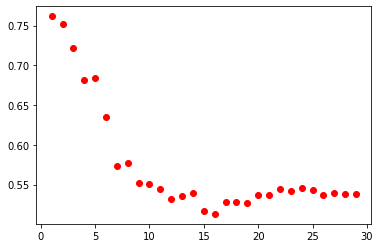

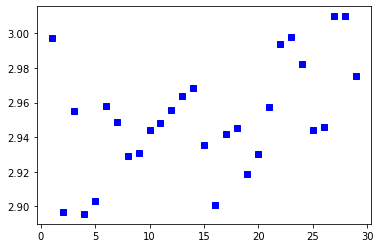

Performing linear SVM!
C = 0.010000, dev error = 0.601300
C = 0.100000, dev error = 0.594500
C = 1.000000, dev error = 0.606000
Selected classifier with best dev error 0.594500
Training time for p2 = 0.30 seconds
Performing linear SVM!
C = 0.010000, dev error = 0.775200
C = 0.100000, dev error = 0.772100
C = 1.000000, dev error = 0.765600
Selected classifier with best dev error 0.765600
Total time = 2.92 seconds
Performing linear SVM!
C = 0.010000, dev error = 0.782100
C = 0.100000, dev error = 0.758600
C = 1.000000, dev error = 0.746100
Selected classifier with best dev error 0.746100
Total time = 3.03 seconds
Performing linear SVM!
C = 0.010000, dev error = 0.740700
C = 0.100000, dev error = 0.711300
C = 1.000000, dev error = 0.689700
Selected classifier with best dev error 0.689700
Total time = 2.96 seconds
Performing linear SVM!
C = 0.010000, dev error = 0.749200
C = 0.100000, dev error = 0.664100
C = 1.000000, dev error = 0.643000
Selected classifier with best dev error 0.643000
T

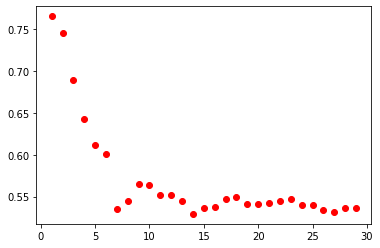

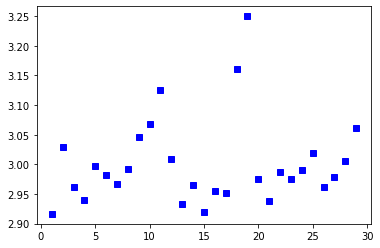

In [75]:
# TODO: (add your code below) Write code to complete 3.5.1
#   Feel free to copy code from above cells and add new cells. 
start_time = time.time()
raw_best_error_dev, raw_pred = linear_svm(
    train_x_small_set['p1'], train_y_small_set['p1'], 
    dev_x_sample, dev_y_sample, 
    test_x_sample
)
end_time = time.time()
print(f'Training time for p1 = {end_time - start_time:.2f} seconds')



n_component_candidates = range(1,30)


total_time_list=[]

error_list=[]

for n_components in n_component_candidates:

  start_time = time.time()
  
  pca = PCA(n_components)

  # train
  pca.fit(train_x_sample)

  # transform
  z_pca_tr_1 = pca.transform(train_x_small_set['p1'])
  z_pca_dev = pca.transform(dev_x_sample)
  z_pca_te = pca.transform(test_x_sample)


  pc_best_error_dev, pc_pred = linear_svm(
      z_pca_tr_1, train_y_small_set['p1'], 
      z_pca_dev, dev_y_sample, 
      z_pca_te
  )
  end_time = time.time()
  error_list.append(pc_best_error_dev)
  print(f'Total time = {end_time - start_time:.2f} seconds')
  total_time_list.append(end_time - start_time)

# (add your code above)
plt.plot(n_component_candidates, error_list, 'ro')
plt.show()
plt.plot(n_component_candidates, total_time_list, 'bs')
plt.show()

######### p2########################################

start_time = time.time()
raw_best_error_dev, raw_pred = linear_svm(
    train_x_small_set['p2'], train_y_small_set['p2'], 
    dev_x_sample, dev_y_sample, 
    test_x_sample
)
end_time = time.time()
print(f'Training time for p2 = {end_time - start_time:.2f} seconds')

n_component_candidates = range(1,30)


total_time_list=[]

error_list=[]

for n_components in n_component_candidates:

  start_time = time.time()
  
  pca = PCA(n_components)

  # train
  pca.fit(train_x_sample)

  # transform
  z_pca_tr_2 = pca.transform(train_x_small_set['p2'])
  z_pca_dev = pca.transform(dev_x_sample)
  z_pca_te = pca.transform(test_x_sample)


  pc_best_error_dev, pc_pred = linear_svm(
      z_pca_tr_2, train_y_small_set['p2'], 
      z_pca_dev, dev_y_sample, 
      z_pca_te
  )
  end_time = time.time()
  error_list.append(pc_best_error_dev)
  print(f'Total time = {end_time - start_time:.2f} seconds')
  total_time_list.append(end_time - start_time)

# (add your code above)
plt.plot(n_component_candidates, error_list, 'ro')
plt.show()
plt.plot(n_component_candidates, total_time_list, 'bs')
plt.show()

### Answer to 3.5.1 (TODO: add your answer)

Without PCA, for p1 the error rate is around 0.57, for p2, the error rate is around 0.59. the time take for computation is 0.3 seconds. 

For all the PC computation, since there is overhead for computing PC, the time took is around 3.3 seconds, increased from 0.3 seconds.

For p1, the lowest error rate is when number of PC = 15, with error rate of 0.53.

For p2, the lowest error rate is when number of PC = 7 , with error rate of 0.53.

Overall, the error rate decreased but time increased

Data path is: data/original_distribute.mat


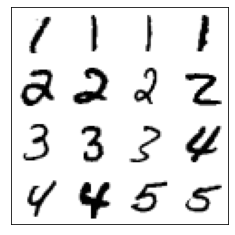

In [7]:
# load the original MNIST data
datapath = 'data/original_distribute.mat'
print("Data path is: %s" % datapath)

train_data_orig, dev_data_orig, test_data_orig = read_mnist(datapath)
test_x_sample_orig = test_data_orig
test_x_image_orig = np.reshape(
        test_x_sample_orig, [test_x_sample_orig.shape[0], 28, 28]
    ).transpose(0, 2, 1)
train_x_sample_orig = train_data_orig.images
train_x_image_orig = np.reshape(
        train_x_sample_orig, [train_x_sample_orig.shape[0], 28, 28]
    ).transpose(0, 2, 1)
train_y_sample_orig = np.reshape(
    train_data_orig.labels, [train_x_sample_orig.shape[0]]
)
dev_x_sample_orig = dev_data_orig.images
dev_x_image_orig = np.reshape(
        dev_x_sample_orig, [dev_x_sample_orig.shape[0], 28, 28]
    ).transpose(0, 2, 1)
dev_y_sample_orig = np.reshape(
    dev_data_orig.labels, [dev_x_sample_orig.shape[0]]
)

# visualize a few to see if we're loading the correct data
ax = plot_images(train_x_image_orig[::1500], 4, 4, 28, 28)
plt.show()

# create small set version for original dataset
ids = sio.loadmat('data/idx.mat')
train_x_small_set_orig = dict()
train_y_small_set_orig = dict()
train_x_small_set_orig['p1'] = train_x_sample_orig[ids['p1'].reshape(-1)]
train_y_small_set_orig['p1'] = train_y_sample_orig[ids['p1'].reshape(-1)]
train_x_small_set_orig['p2'] = train_x_sample_orig[ids['p2'].reshape(-1)]
train_y_small_set_orig['p2'] = train_y_sample_orig[ids['p2'].reshape(-1)]

Performing linear SVM!
C = 0.010000, dev error = 0.434200
C = 0.100000, dev error = 0.423300
C = 1.000000, dev error = 0.428200
Selected classifier with best dev error 0.423300
Training time for p1 = 0.26 seconds
Performing linear SVM!
C = 0.010000, dev error = 0.591500
C = 0.100000, dev error = 0.566300
C = 1.000000, dev error = 0.502400
Selected classifier with best dev error 0.502400
Total time = 3.17 seconds
Performing linear SVM!
C = 0.010000, dev error = 0.541000
C = 0.100000, dev error = 0.514000
C = 1.000000, dev error = 0.488000
Selected classifier with best dev error 0.488000
Total time = 2.96 seconds
Performing linear SVM!
C = 0.010000, dev error = 0.509400
C = 0.100000, dev error = 0.482500
C = 1.000000, dev error = 0.481700
Selected classifier with best dev error 0.481700
Total time = 3.03 seconds
Performing linear SVM!
C = 0.010000, dev error = 0.465400
C = 0.100000, dev error = 0.438200
C = 1.000000, dev error = 0.440500
Selected classifier with best dev error 0.438200
T

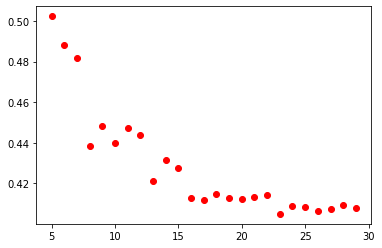

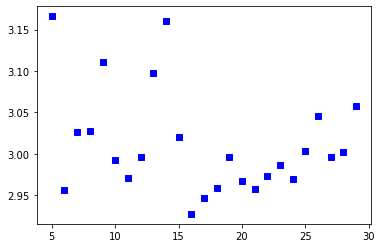

Performing linear SVM!
C = 0.010000, dev error = 0.411500
C = 0.100000, dev error = 0.378900
C = 1.000000, dev error = 0.376800
Selected classifier with best dev error 0.376800
Training time for p2 = 0.27 seconds
Performing linear SVM!
C = 0.010000, dev error = 0.571800
C = 0.100000, dev error = 0.561200
C = 1.000000, dev error = 0.541300
Selected classifier with best dev error 0.541300
Total time = 2.90 seconds
Performing linear SVM!
C = 0.010000, dev error = 0.505200
C = 0.100000, dev error = 0.484100
C = 1.000000, dev error = 0.457300
Selected classifier with best dev error 0.457300
Total time = 2.91 seconds
Performing linear SVM!
C = 0.010000, dev error = 0.494200
C = 0.100000, dev error = 0.488600
C = 1.000000, dev error = 0.441000
Selected classifier with best dev error 0.441000
Total time = 2.95 seconds
Performing linear SVM!
C = 0.010000, dev error = 0.435300
C = 0.100000, dev error = 0.420500
C = 1.000000, dev error = 0.402900
Selected classifier with best dev error 0.402900
T

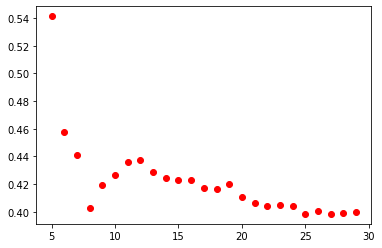

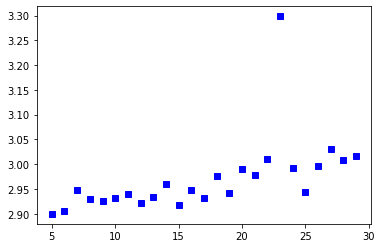

In [77]:
# TODO: (add your code below) complete your code for 3.5.2 

start_time = time.time()
raw_best_error_dev, raw_pred = linear_svm(
    train_x_small_set_orig['p1'], train_y_small_set_orig['p1'], 
    dev_x_sample_orig, dev_y_sample_orig, 
    test_x_sample_orig
)
end_time = time.time()
print(f'Training time for p1 = {end_time - start_time:.2f} seconds')



n_component_candidates = range(5,30)


total_time_list=[]

error_list=[]

for n_components in n_component_candidates:

  start_time = time.time()
  
  pca = PCA(n_components)

  # train
  pca.fit(train_x_sample_orig)

  # transform
  z_pca_tr_1 = pca.transform(train_x_small_set_orig['p1'])
  z_pca_dev = pca.transform(dev_x_sample_orig)
  z_pca_te = pca.transform(test_x_sample_orig)


  pc_best_error_dev, pc_pred = linear_svm(
      np.real(z_pca_tr_1), train_y_small_set_orig['p1'], 
      np.real(z_pca_dev), dev_y_sample_orig,
      np.real(z_pca_te)
  )
  end_time = time.time()
  error_list.append(pc_best_error_dev)
  print(f'Total time = {end_time - start_time:.2f} seconds')
  total_time_list.append(end_time - start_time)

# (add your code above)
plt.plot(n_component_candidates, error_list, 'ro')
plt.show()
plt.plot(n_component_candidates, total_time_list, 'bs')
plt.show()

########################p2###################################################


start_time = time.time()
raw_best_error_dev, raw_pred = linear_svm(
    train_x_small_set_orig['p2'], train_y_small_set_orig['p2'], 
    dev_x_sample_orig, dev_y_sample_orig, 
    test_x_sample_orig
)
end_time = time.time()
print(f'Training time for p2 = {end_time - start_time:.2f} seconds')
n_component_candidates = range(5,30)


total_time_list=[]

error_list=[]

for n_components in n_component_candidates:

  start_time = time.time()
  
  pca = PCA(n_components)

  # train
  pca.fit(train_x_sample_orig)

  # transform
  z_pca_tr_2 = pca.transform(train_x_small_set_orig['p2'])
  z_pca_dev = pca.transform(dev_x_sample_orig)
  z_pca_te = pca.transform(test_x_sample_orig)

  pc_best_error_dev, pc_pred = linear_svm(
      np.real(z_pca_tr_2), train_y_small_set_orig['p2'], 
      np.real(z_pca_dev), dev_y_sample_orig, 
      np.real(z_pca_te)
  )
  end_time = time.time()
  error_list.append(pc_best_error_dev)
  print(f'Total time = {end_time - start_time:.2f} seconds')
  total_time_list.append(end_time - start_time)

# (add your code above)
plt.plot(n_component_candidates, error_list, 'ro')
plt.show()
plt.plot(n_component_candidates, total_time_list, 'bs')
plt.show()

### Answer to 3.5.2 (TODO: add your answer)

For all the PC picked, the error rate did not decrease significantly or at all; most of PC options have higher error rate. On the other hand, the dataset with noise, PC was able to produce lower error rate result. Time is as expected increased from 0.3 second to 3 seconds

### Answer to 3.5.3 (TODO: add your answer)

The experiment is unsuccessful as it encounter complex value

When have enough data, more dimension would produce better result ( lower error rate) However, when there is not enough data, the number of PC produced best result is significantly lower.

Extra Credit: Implement SVD

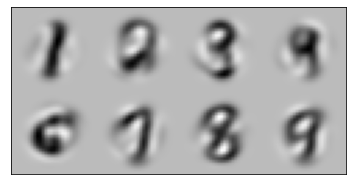

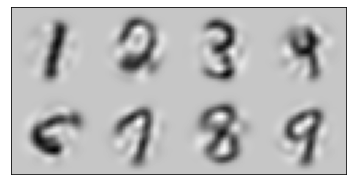

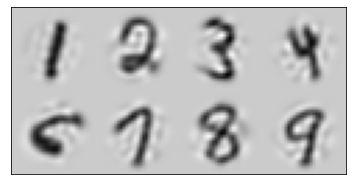

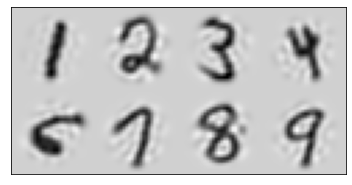

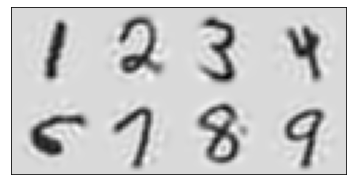

In [10]:
n_component_candidates = [20,40,60,80,100
]  

for n_components in n_component_candidates:
    # TODO: (add your code below) compress the data with PCA and the specific 
    #   n_components, reconstruct the digits, and plot some examples 
    # hint: feel free to copy code from the above cells. 

    pca = PCA(n_components)

    # train
    pca.fit_svd(train_x_sample)

    # transform
    z_pca_dev = pca.transform(dev_x_sample)

    # reconstruct
    dev_x_image_hat = pca.reconstruct(z_pca_dev).reshape(
        (-1, 28, 28)).transpose((0, 2, 1))
    ax = plot_images(dev_x_image_hat[::1250], 2, 4, 28, 28)
    plt.show()    

    # (add your code above)

Performing linear SVM!
C = 0.010000, dev error = 0.275200
C = 0.100000, dev error = 0.273200
C = 1.000000, dev error = 0.273000
Selected classifier with best dev error 0.273000
Total time = 19.13 seconds
Performing linear SVM!
C = 0.010000, dev error = 0.231500
C = 0.100000, dev error = 0.229600
C = 1.000000, dev error = 0.229300
Selected classifier with best dev error 0.229300
Total time = 25.70 seconds
Performing linear SVM!
C = 0.010000, dev error = 0.217100
C = 0.100000, dev error = 0.214100
C = 1.000000, dev error = 0.213800
Selected classifier with best dev error 0.213800
Total time = 34.31 seconds
Performing linear SVM!
C = 0.010000, dev error = 0.210600
C = 0.100000, dev error = 0.208700
C = 1.000000, dev error = 0.208300
Selected classifier with best dev error 0.208300
Total time = 45.18 seconds
Performing linear SVM!
C = 0.010000, dev error = 0.208600
C = 0.100000, dev error = 0.206500
C = 1.000000, dev error = 0.206000
Selected classifier with best dev error 0.206000
Total t

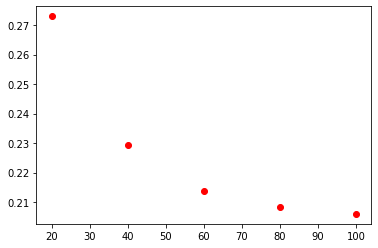

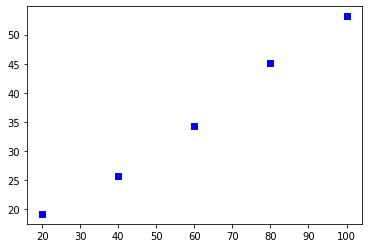

In [15]:
n_component_candidates = [20,40,60,80,100
]  

total_time_list=[]

error_list=[]

for n_components in n_component_candidates:

  start_time = time.time()
  
  pca = PCA(n_components)

  # train
  pca.fit_svd(train_x_sample)

  # transform
  z_pca_tr = pca.transform(train_x_sample)
  z_pca_dev = pca.transform(dev_x_sample)
  z_pca_te = pca.transform(test_x_sample)


  svm_st_time = time.time()
  pc_best_error_dev, pc_pred = linear_svm(
      z_pca_tr, train_y_sample, 
      z_pca_dev, dev_y_sample, 
      z_pca_te
  )
  end_time = time.time()
  error_list.append(pc_best_error_dev)
  print(f'Total time = {end_time - start_time:.2f} seconds')
  total_time_list.append(end_time - start_time)

# (add your code above)
plt.plot(n_component_candidates, error_list, 'ro')
plt.show()
plt.plot(n_component_candidates, total_time_list, 'bs')
plt.show()

# (add your code above)

Performing linear SVM!
C = 0.010000, dev error = 0.844800
C = 0.100000, dev error = 0.834900
C = 1.000000, dev error = 0.761800
Selected classifier with best dev error 0.761800
Total time = 11.01 seconds
Performing linear SVM!
C = 0.010000, dev error = 0.821400
C = 0.100000, dev error = 0.813000
C = 1.000000, dev error = 0.752200
Selected classifier with best dev error 0.752200
Total time = 10.58 seconds
Performing linear SVM!
C = 0.010000, dev error = 0.781500
C = 0.100000, dev error = 0.773000
C = 1.000000, dev error = 0.722200
Selected classifier with best dev error 0.722200
Total time = 10.47 seconds
Performing linear SVM!
C = 0.010000, dev error = 0.752500
C = 0.100000, dev error = 0.736300
C = 1.000000, dev error = 0.681800
Selected classifier with best dev error 0.681800
Total time = 10.53 seconds
Performing linear SVM!
C = 0.010000, dev error = 0.734900
C = 0.100000, dev error = 0.715000
C = 1.000000, dev error = 0.683600
Selected classifier with best dev error 0.683600
Total t

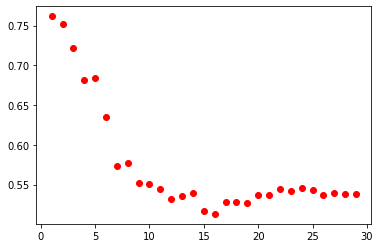

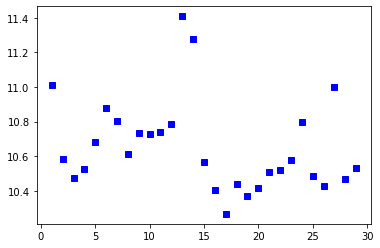

In [16]:
n_component_candidates = range(1,30)


total_time_list=[]

error_list=[]

for n_components in n_component_candidates:

  start_time = time.time()
  
  pca = PCA(n_components)

  # train
  pca.fit_svd(train_x_sample)

  # transform
  z_pca_tr_1 = pca.transform(train_x_small_set['p1'])
  z_pca_dev = pca.transform(dev_x_sample)
  z_pca_te = pca.transform(test_x_sample)


  pc_best_error_dev, pc_pred = linear_svm(
      z_pca_tr_1, train_y_small_set['p1'], 
      z_pca_dev, dev_y_sample, 
      z_pca_te
  )
  end_time = time.time()
  error_list.append(pc_best_error_dev)
  print(f'Total time = {end_time - start_time:.2f} seconds')
  total_time_list.append(end_time - start_time)

# (add your code above)
plt.plot(n_component_candidates, error_list, 'ro')
plt.show()
plt.plot(n_component_candidates, total_time_list, 'bs')
plt.show()

SVD report: the SVD implementation take significantly longer time than eigendecomposition implementation. Took about twice as much of time to compute. The error rate is about the same. No major accuracy difference is observed

## Part 2: Multiview Dimensionality Reduction with CCA


Calculate Covariance of $C_{xx},C_{xy},C_{yx},C_{yy}$

Find eigenvector of matrix $C_{xx}^{-1}C_{xy}C_{yy}^{-1}C_{yx}$

Project data


Data path is: data/noisy_two_view_distribute.mat


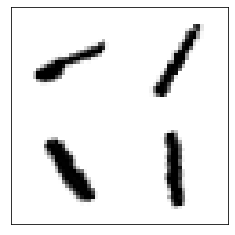

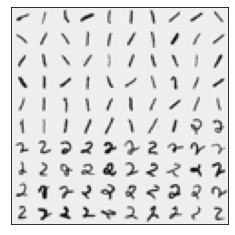

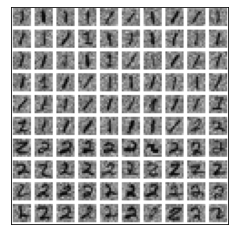

In [78]:
np.random.seed(1)

datapath="data/noisy_two_view_distribute.mat"
print("Data path is: %s" % datapath)

train_data, dev_data, test_data, test_data2 = read_mnist_twoview(datapath)
test_x_sample = test_data
test_x_sample2 = test_data2
test_x_image = np.reshape(
        test_x_sample, [test_x_sample.shape[0], 28, 28]
    ).transpose(0, 2, 1)
test_x_image2 = np.reshape(
        test_x_sample2, [test_x_sample2.shape[0], 28, 28]
    ).transpose(0, 2, 1)
train_x_sample = train_data.images
train_x_sample2 = train_data.images2
train_x_image = np.reshape(
        train_x_sample, [train_x_sample.shape[0], 28, 28]
    ).transpose(0, 2, 1)
train_x_image2 = np.reshape(
        train_x_sample2, [train_x_sample2.shape[0], 28, 28]
    ).transpose(0, 2, 1)
train_y_sample = np.reshape(train_data.labels, [train_x_sample.shape[0]])
dev_x_sample = dev_data.images
dev_x_sample2 = dev_data.images2
dev_x_image = np.reshape(
        dev_x_sample, [dev_x_sample.shape[0], 28, 28]
    ).transpose(0, 2, 1)
dev_x_image2 = np.reshape(
        dev_x_sample2, [dev_x_sample2.shape[0], 28, 28]
    ).transpose(0, 2, 1)
dev_y_sample = np.reshape(dev_data.labels, [dev_x_sample.shape[0]])

"""
1. Visualize a few input digits
"""
ax = plot_images(train_x_image[::1500], 2, 2, 28, 28)
plt.show()


"""
2. Visualize more input digits, using smaller scale
"""
train_x_rescale = resize(train_x_image, 10, 10)
ax = plot_images(train_x_rescale[::100], 10, 10, 10, 10)
plt.show()

train_x_rescale2 = resize(train_x_image2, 10, 10)
ax = plot_images(train_x_rescale2[::100], 10, 10, 10, 10)
plt.show()

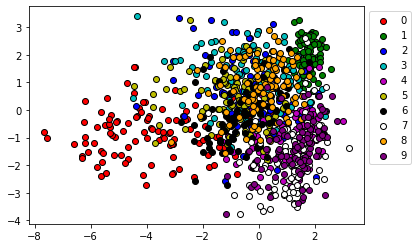

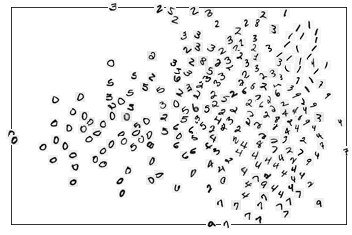

In [79]:
"""
3. Reduce dimension with CCA
"""

n_components, r1, r2 = 20, 1.0, 1.0

cca = CCA(n_components, r1, r2)

# train
cca.fit(train_x_sample, train_x_sample2)

# transform
z_cca_train = cca.transform(train_x_sample)
z_cca_dev = cca.transform(dev_x_sample)
z_cca_test = cca.transform(test_x_sample)

# Visualization without annotation
vis_sample_rate = 10
plot_embedding(
    z_cca_dev[::vis_sample_rate, :2], dev_y_sample[::vis_sample_rate]
)
plt.show()

# Visualization with annotation
dev_x_rescale = resize(dev_x_image,10,10)
plot_embedding_annotation(
    z_cca_dev[::vis_sample_rate, :2], dev_x_rescale[::vis_sample_rate], 0.001
)
plt.show()


If your code works well, the above figures are what we would like for 4.2 

In [80]:
# TODO (add your code below) Write code to complete 4.3.1. 

cc_best_error_dev, cc_pred = linear_svm(
      np.real(z_cca_train), train_y_sample, 
      np.real(z_cca_dev), dev_y_sample,
      np.real(z_cca_test)
  )
# (add your code above)


Performing linear SVM!
C = 0.010000, dev error = 0.238700
C = 0.100000, dev error = 0.238200
C = 1.000000, dev error = 0.238100
Selected classifier with best dev error 0.238100


In [81]:
# TODO (add your code below) Write code to complete 4.3.2. 

raw_best_error_dev, raw_pred = linear_svm(
      train_x_sample, train_y_sample, 
      np.real(dev_x_sample), dev_y_sample,
      np.real(test_x_sample)
  )

# (add your code above)

Performing linear SVM!
C = 0.010000, dev error = 0.197300
C = 0.100000, dev error = 0.200000
C = 1.000000, dev error = 0.203700
Selected classifier with best dev error 0.197300


### Answer to 4.3.2 (TODO: add your answer) 
Accoring to the above results, we find that using the raw features in the data-sufficient settings is still better than using the CCA compressed features to train SVM (0.197 vs. 0.238). However, it does take significantly longer time to process.


Performing linear SVM!
C = 0.010000, dev error = 0.243200
C = 0.100000, dev error = 0.242100
C = 1.000000, dev error = 0.241900
Selected classifier with best dev error 0.241900
Performing linear SVM!
C = 0.010000, dev error = 0.221500
C = 0.100000, dev error = 0.219300
C = 1.000000, dev error = 0.219200
Selected classifier with best dev error 0.219200
Performing linear SVM!
C = 0.010000, dev error = 0.213600
C = 0.100000, dev error = 0.210800
C = 1.000000, dev error = 0.210500
Selected classifier with best dev error 0.210500
Performing linear SVM!
C = 0.010000, dev error = 0.207400
C = 0.100000, dev error = 0.204900
C = 1.000000, dev error = 0.204500
Selected classifier with best dev error 0.204500
Performing linear SVM!
C = 0.010000, dev error = 0.202000
C = 0.100000, dev error = 0.199600
C = 1.000000, dev error = 0.199400
Selected classifier with best dev error 0.199400
Performing linear SVM!
C = 0.010000, dev error = 0.203300
C = 0.100000, dev error = 0.201700
C = 1.000000, dev erro

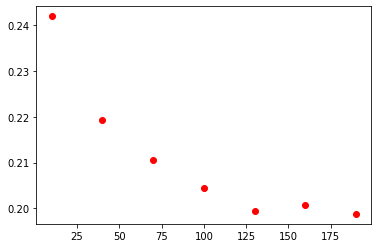

In [84]:
# TODO (add your code below) Write code to complete 4.3.3. 
#   Reminder: you need to explore different groups of hyperparameters. 
#   Feel free to add new cells below. 
error_list=[]

r1, r2 = 0.5, 0.5
n_component_candidates = range(10,200,30)

for n_components in n_component_candidates: 
  cca = CCA(n_components, r1, r2) 

  # train
  cca.fit(train_x_sample, train_x_sample2)  

  # transform
  z_cca_train = cca.transform(train_x_sample)
  z_cca_dev = cca.transform(dev_x_sample)
  z_cca_test = cca.transform(test_x_sample) 

  cc_best_error_dev, cc_pred = linear_svm(
        np.real(z_cca_train), train_y_sample, 
        np.real(z_cca_dev), dev_y_sample,
        np.real(z_cca_test)
    )
  error_list.append(cc_best_error_dev)

# (add your code above)
plt.plot(n_component_candidates, error_list, 'ro')
plt.show()


Performing linear SVM!
C = 0.010000, dev error = 0.204400
C = 0.100000, dev error = 0.202200
C = 1.000000, dev error = 0.201800
Selected classifier with best dev error 0.201800
Performing linear SVM!
C = 0.010000, dev error = 0.202700
C = 0.100000, dev error = 0.200600
C = 1.000000, dev error = 0.200100
Selected classifier with best dev error 0.200100
Performing linear SVM!
C = 0.010000, dev error = 0.202000
C = 0.100000, dev error = 0.199600
C = 1.000000, dev error = 0.199400
Selected classifier with best dev error 0.199400
Performing linear SVM!
C = 0.010000, dev error = 0.202100
C = 0.100000, dev error = 0.201200
C = 1.000000, dev error = 0.200900
Selected classifier with best dev error 0.200900


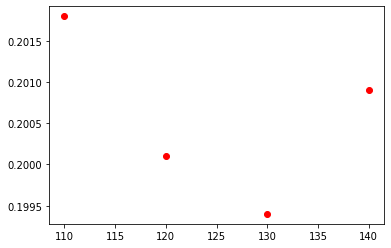

In [85]:
# TODO (add your code below) Write code to complete 4.3.3. 
#   Reminder: you need to explore different groups of hyperparameters. 
#   Feel free to add new cells below. 
error_list=[]

r1, r2 = 0.5, 0.5
n_component_candidates = range(110,150,10)

for n_components in n_component_candidates: 
  cca = CCA(n_components, r1, r2) 

  # train
  cca.fit(train_x_sample, train_x_sample2)  

  # transform
  z_cca_train = cca.transform(train_x_sample)
  z_cca_dev = cca.transform(dev_x_sample)
  z_cca_test = cca.transform(test_x_sample) 

  cc_best_error_dev, cc_pred = linear_svm(
        np.real(z_cca_train), train_y_sample, 
        np.real(z_cca_dev), dev_y_sample,
        np.real(z_cca_test)
    )
  error_list.append(cc_best_error_dev)

# (add your code above)
plt.plot(n_component_candidates, error_list, 'ro')
plt.show()


Performing linear SVM!
C = 0.010000, dev error = 0.202500
C = 0.100000, dev error = 0.199200
C = 1.000000, dev error = 0.199300
Selected classifier with best dev error 0.199200
Performing linear SVM!
C = 0.010000, dev error = 0.202000
C = 0.100000, dev error = 0.199600
C = 1.000000, dev error = 0.199400
Selected classifier with best dev error 0.199400
Performing linear SVM!
C = 0.010000, dev error = 0.202500
C = 0.100000, dev error = 0.199500
C = 1.000000, dev error = 0.199200
Selected classifier with best dev error 0.199200
Performing linear SVM!
C = 0.010000, dev error = 0.202500
C = 0.100000, dev error = 0.200100
C = 1.000000, dev error = 0.199300
Selected classifier with best dev error 0.199300


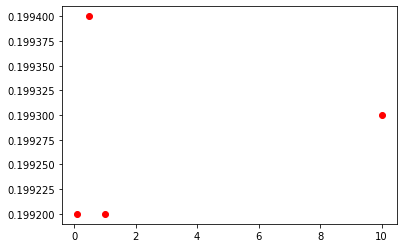

In [88]:
# TODO (add your code below) Write code to complete 4.3.3. 
#   Reminder: you need to explore different groups of hyperparameters. 
#   Feel free to add new cells below. 
error_list=[]

n_components = 130
r_candidates = [0.1,0.5,1,10]

for r in r_candidates: 
  cca = CCA(n_components, r, r) 

  # train
  cca.fit(train_x_sample, train_x_sample2)  

  # transform
  z_cca_train = cca.transform(train_x_sample)
  z_cca_dev = cca.transform(dev_x_sample)
  z_cca_test = cca.transform(test_x_sample) 

  cc_best_error_dev, cc_pred = linear_svm(
        np.real(z_cca_train), train_y_sample, 
        np.real(z_cca_dev), dev_y_sample,
        np.real(z_cca_test)
    )
  error_list.append(cc_best_error_dev)

# (add your code above)
plt.plot(r_candidates, error_list, 'ro')
plt.show()


### Answer to 4.3.3 (TODO: add your answer)
The best hyperparameter is to have r1, r2 = 1 and 130 dimensions. However, it is not much different with the regularization coefficient


In [89]:
# prepare the 50-example data for CCA 

ids = sio.loadmat('data/idx.mat')
train_x_small_set = dict()
train_y_small_set = dict()
for partition in ['p1', 'p2']:
    train_x_small_set[partition] = train_x_sample[ids[partition].reshape(-1)]
    train_y_small_set[partition] = train_y_sample[ids[partition].reshape(-1)]

Performing linear SVM!
C = 0.010000, dev error = 0.586400
C = 0.100000, dev error = 0.570400
C = 1.000000, dev error = 0.576300
Selected classifier with best dev error 0.570400
Performing linear SVM!
C = 0.010000, dev error = 0.833600
C = 0.100000, dev error = 0.826600
C = 1.000000, dev error = 0.760100
Selected classifier with best dev error 0.760100
Performing linear SVM!
C = 0.010000, dev error = 0.734700
C = 0.100000, dev error = 0.683300
C = 1.000000, dev error = 0.625600
Selected classifier with best dev error 0.625600
Performing linear SVM!
C = 0.010000, dev error = 0.622900
C = 0.100000, dev error = 0.578300
C = 1.000000, dev error = 0.544200
Selected classifier with best dev error 0.544200
Performing linear SVM!
C = 0.010000, dev error = 0.556000
C = 0.100000, dev error = 0.525200
C = 1.000000, dev error = 0.502900
Selected classifier with best dev error 0.502900
Performing linear SVM!
C = 0.010000, dev error = 0.525100
C = 0.100000, dev error = 0.486400
C = 1.000000, dev erro

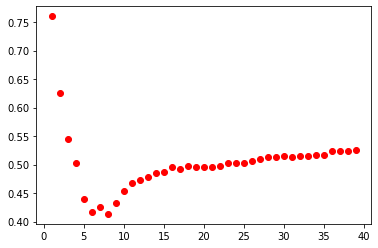

In [91]:
# TODO: (add your code below) Implement the experiments to complete 4.4 
raw_best_error_dev, raw_pred = linear_svm(
      np.real(train_x_small_set['p1']), train_y_small_set['p1'], 
      np.real(dev_x_sample), dev_y_sample,
      np.real(test_x_sample)
  )



error_list=[]

r1, r2 = 1, 1
n_component_candidates = range(1,40)

for n_components in n_component_candidates: 
  cca = CCA(n_components, r1, r2) 

  # train
  cca.fit(train_x_sample, train_x_sample2)  

  # transform
  z_cca_train = cca.transform(train_x_small_set['p1'])
  z_cca_dev = cca.transform(dev_x_sample)
  z_cca_test = cca.transform(test_x_sample) 

  cc_best_error_dev, cc_pred = linear_svm(
        np.real(z_cca_train), train_y_small_set['p1'], 
        np.real(z_cca_dev), dev_y_sample,
        np.real(z_cca_test)
    )
  error_list.append(cc_best_error_dev)

# (add your code above)
plt.plot(n_component_candidates, error_list, 'ro')
plt.show()


Performing linear SVM!
C = 0.010000, dev error = 0.601300
C = 0.100000, dev error = 0.594500
C = 1.000000, dev error = 0.606000
Selected classifier with best dev error 0.594500
Performing linear SVM!
C = 0.010000, dev error = 0.810400
C = 0.100000, dev error = 0.806200
C = 1.000000, dev error = 0.748300
Selected classifier with best dev error 0.748300
Performing linear SVM!
C = 0.010000, dev error = 0.677700
C = 0.100000, dev error = 0.668500
C = 1.000000, dev error = 0.644400
Selected classifier with best dev error 0.644400
Performing linear SVM!
C = 0.010000, dev error = 0.561600
C = 0.100000, dev error = 0.544600
C = 1.000000, dev error = 0.530400
Selected classifier with best dev error 0.530400
Performing linear SVM!
C = 0.010000, dev error = 0.521000
C = 0.100000, dev error = 0.520500
C = 1.000000, dev error = 0.503600
Selected classifier with best dev error 0.503600
Performing linear SVM!
C = 0.010000, dev error = 0.459900
C = 0.100000, dev error = 0.439100
C = 1.000000, dev erro

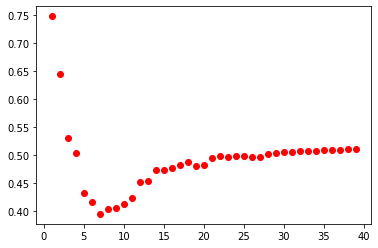

In [92]:
# TODO: (add your code below) Implement the experiments to complete 4.4 
raw_best_error_dev, raw_pred = linear_svm(
      np.real(train_x_small_set['p2']), train_y_small_set['p2'], 
      np.real(dev_x_sample), dev_y_sample,
      np.real(test_x_sample)
  )



error_list=[]

r1, r2 = 1, 1
n_component_candidates = range(1,40)

for n_components in n_component_candidates: 
  cca = CCA(n_components, r1, r2) 

  # train
  cca.fit(train_x_sample, train_x_sample2)  

  # transform
  z_cca_train = cca.transform(train_x_small_set['p2'])
  z_cca_dev = cca.transform(dev_x_sample)
  z_cca_test = cca.transform(test_x_sample) 

  cc_best_error_dev, cc_pred = linear_svm(
        np.real(z_cca_train), train_y_small_set['p2'], 
        np.real(z_cca_dev), dev_y_sample,
        np.real(z_cca_test)
    )
  error_list.append(cc_best_error_dev)

# (add your code above)
plt.plot(n_component_candidates, error_list, 'ro')
plt.show()


### Answer to 4.4 (TODO: add your answer) 

CCA is significantly performed better at small training dataset than PCA performed. 

For P1, The error rate decreased from 0.57 (raw data) to 0.42 (8 dimensions). For P2, the error rate decreased from 0.59 to 0.40 (7 dimensions)



# Export to PDF
Note: simply printing to PDF may lose content if you have too much output from one cell.

In [18]:
from google.colab import drive, files
drive.mount('/content/drive')
# follow the prompt to mount your Google Drive to the Colab machine
! cp drive/MyDrive/TTIC31220-Winter21/QingyuanLiu_2021_ttic31220_hw1.ipynb ./
# Note: if you changed the path of your colab notebook in your Google Drive, 
# you might need to modify the above source path accordingly
! apt-get update
! apt-get install texlive texlive-xetex texlive-latex-extra pandoc
! pip install pypandoc
! jupyter nbconvert --to PDF "QingyuanLiu_2021_ttic31220_hw1.ipynb"
files.download('QingyuanLiu_2021_ttic31220_hw1.pdf')
# As a reminder, you will need to submit both the PDF file and this Jupyter 
#   notebook.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:14 h

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>